In [16]:
import pandas as pd
import numpy as np
import verispy, os
from verispy import VERIS
import seaborn as sns
from util import constants as cst
import matplotlib as plt

[Source for VERISPY + Useful README](https://github.com/RiskLens/verispy)

In [17]:
DATA_DIR ="./data/validated"
v = VERIS(json_dir=DATA_DIR)
vdf = v.json_to_df(keep_raw=True)
print(vdf.shape)

  0%|          | 0/8363 [00:00<?, ?it/s]

Found 8363 json files.
Loading schema
Loading JSON files to DataFrame.


  0%|          | 0/173 [00:00<?, ?it/s]

Finished loading JSON files to dataframe.
Building DataFrame with enumerations.
Building enumeration columns.


100%|██████████| 173/173 [00:05<00:00, 29.28it/s]


Done building DataFrame with enumerations.
Post-Processing DataFrame (A4 Names, Victim Industries, Patterns)
Finished building VERIS DataFrame
(8363, 2347)


##### v is a VERIS object. vdf contains the actual data. 

In [18]:
# f, ax = plt.subplots(figsize=(7, 3), sharex=True)

vdf.rename(columns={'attribute.confidentiality.data_total': 'records_lost'}, inplace=True)
vdf['action.Bugs'] = vdf['action.Hacking'] | vdf['action.Malware']
vdf
# vdf.assign('action.Bugs')
# vdf = vdf.sample(1000)
# sns.catplot(y='records_lost', data=vdf, kind="violin")

# adf=pd.Series()

vdf_loss = vdf.dropna(subset=["records_lost"])

# vdf_loss['records_lost']
# print(v.enum_summary(vdf_loss, 'records_lost')
# sns.catplot(y=vdf_loss['records_lost'], orient="h", kind="violin")

Total Records Breached, Log Normalized

In [19]:
# for a in cst.ACTIONS:
#     adf[a] = vdf_loss[vdf_loss[a]==True]
    
# adf['action.Environmental']
# adf['action.Hacking']['records_lost']
# # plt.hist(adf['action.Hacking']['records_lost'])
# plt.setscale("log")
# print(adf[cst.ACTIONS])
# sns.distplot(adf[cst.ACTIONS]['records_lost'])?

vdf_final = vdf_loss.copy()
print()

In [20]:
# def assign_bugs(row):
#     return row.loc['action.Malware'] | row['action.Hacking']
# vdf_final[{'action.Malware', 'action.Hacking'}]
# vdf_final.assign('action.Bugs' = lambda x: x['action.Hacking'] | x['action.Bugs'])
# vdf_final[vdf[{'action.Hacking', 'action.Malware'}]==True].index
vdf_final

,action.Environmental,action.Error,action.Hacking,action.Malware,action.Misuse,action.Physical,action.Social,action.Unknown,action.environmental.notes,action.environmental.variety.Deterioration,...,victim.revenue.iso_currency_code.YER,victim.revenue.iso_currency_code.ZAR,victim.revenue.iso_currency_code.ZMK,victim.revenue.iso_currency_code.ZWD,victim.secondary.amount,victim.secondary.notes,victim.secondary.victim_id,victim.state,victim.victim_id,action.Bugs
2,False,False,True,False,False,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,NaN,UA Customs Service,True
5,False,False,False,False,True,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,UT,United States Department of Veterans Affairs,False
7,False,True,False,False,False,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,NY,United States Department of Veterans Affairs,False
8,False,True,False,False,False,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,NaN,HM PASSPORT OFFICE,False
9,False,False,False,False,False,True,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,FL,Ace Homecare LLC,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,False,True,False,False,False,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,NaN,Cambridgeshire and Peterborough NHS Foundation...,False
8356,False,False,False,False,False,True,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,NaN,Epsom and St Helier Hospitals NHS Trust,False
8357,False,False,False,False,True,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,GA,"LabMD, Inc.",False
8360,False,False,False,False,True,False,False,False,NaN,False,...,False,False,False,False,NaN,NaN,NaN,NaN,Peterborough Regional Health Centre,False


In [21]:
# vdf_final['action.']

In [22]:
import logging
import dowhy
import pygraphviz
import dowhy.datasets, dowhy.plotter
try:
    from dowhy import CausalModel
except:
    from dowhy.do_why import CausalModel

In [23]:
import sys
print(sys.version)

3.8.1 | packaged by conda-forge | (default, Jan  5 2020, 20:58:18) 
[GCC 7.3.0]


In [24]:
# Create causal model with instrumental
print(vdf_final['records_lost'])

model = CausalModel(
    data = vdf_final,
    treatment = 'action.Bugs',
    outcome = 'records_lost',
    common_causes = ['action.Environmental', 'action.Error', 'action.Misuse', 'action.Physical', 'action.Social'],
    instruments = ['action.Hacking', 'action.Malware'],
    logging_level = logging.INFO
)
model.view_model(layout="dot")

INFO:dowhy.do_why:Model to find the causal effect of treatment ['action.Bugs'] on outcome ['records_lost']


2         64.0
5          1.0
7          1.0
8          3.0
9         41.0
         ...  
8353      47.0
8356     300.0
8357    9300.0
8360     280.0
8362       1.0
Name: records_lost, Length: 4711, dtype: float64


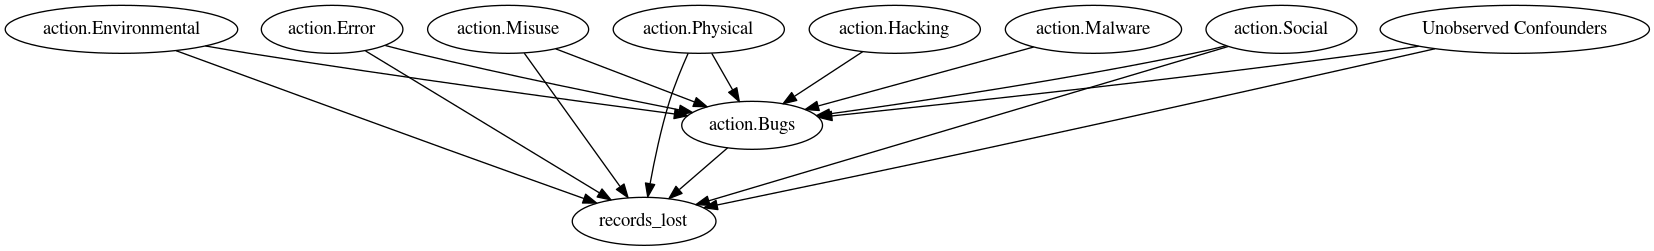

In [25]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [26]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['action.Misuse', 'U', 'action.Environmental', 'action.Physical', 'action.Social', 'action.Error']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['action.Hacking', 'action.Malware']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(records_lost|action.Misuse,action.Environmental,actio
daction.Bugs                                                                  

                                       
n.Physical,action.Social,action.Error))
                                       
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error,U) = P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(records_lost, action.Hacking)/Derivative(action.Bugs, a
ction.Hacking))
Estimand assumption 1, As-if-random: If U→→records_lost then ¬(U →→action.Hacking,action.Malware)
Estimand assum

In [27]:
estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression" )
print("Causal Estimate is " + str(estimate.value))

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error


Causal Estimate is 23069960.93087865


In [28]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['action.Misuse', 'U', 'action.Environmental', 'action.Physical', 'action.Social', 'action.Error']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['action.Hacking', 'action.Malware']


Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(records_lost|action.Misuse,action.Environmental,actio
daction.Bugs                                                                  

                                       
n.Physical,action.Social,action.Error))
                                       
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error,U) = P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(records_lost, action.Hacking)/Derivative(action.Bugs, a
ction.Hacking))
Estimand assumption 1, As-if-random: If U→→records_lost then ¬(U →→action.Hacking,action.Malware)
Estimand assum

## Method 1: Stratification

In [29]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause",test_significance=True)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

print(res_subset)
print(res_random)
print(res_subset)
# model.refute_estimate(identified_estimand, causal_estimate)
# res_random  = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error+w_random


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(records_lost|action.Misuse,action.Environmental,actio
daction.Bugs                                                                  

                                       
n.Physical,action.Social,action.Error))
                                       
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error,U) = P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(records_lost, action.Hacking)/Derivative(action.Bugs, a
ction.Hacking))
Estimand assumption 1, As-if-random: If U→→records_lost then ¬(U →→a

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: records_lost~placebo+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error


Refute: Use a subset of data
Estimated effect:(23069960.93087865,)
New effect:(24619699.05595945,)

Refute: Add a Random Common Cause
Estimated effect:(18344559.74470463,)
New effect:(26770070.282605026,)

Refute: Use a subset of data
Estimated effect:(23069960.93087865,)
New effect:(24619699.05595945,)



## Method 2: Matching

In [32]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

In [32]:
res_random = model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause",test_significance=True)

res_placebo=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")

res_subset=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter", subset_fraction=0.9)

print(res_subset)
print(res_random)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error
/home/jakes/anaconda3/envs/cb/lib/python3.8/site-packages/dowhy/causal_estimators/propensity_score_matching_estimator.py:51: FutureWarning: `item` has been deprecated and will be removed in a future version
  control_outcome = control.iloc[indices[i]][self._outcome_name].item()
INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: records_lost~action.Bugs+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error+w_random
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: records_lost~placebo+action.Misuse+action.Environmental+action.Physical+action.Social+action.Error
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_es

*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                                                        
────────────(Expectation(records_lost|action.Misuse,action.Environmental,actio
daction.Bugs                                                                  

                                       
n.Physical,action.Social,action.Error))
                                       
Estimand assumption 1, Unconfoundedness: If U→action.Bugs and U→records_lost then P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error,U) = P(records_lost|action.Bugs,action.Misuse,action.Environmental,action.Physical,action.Social,action.Error)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(records_lost, action.Hacking)/Derivative(action.Bugs, a
ction.Hacking))
Estimand assumption 1, As-if-random: If U→→records_lost then ¬(U →→a